In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Lambda, BatchNormalization, Bidirectional

In [2]:
# 코랩 사용시 데이터 불러오기 코드
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/data/data.csv' # 데이터 위치한 구글 드라이브 경로로 수정
data = pd.read_csv(filename)
data = data.set_index('Date')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 로컬 사용시 데이터 불러오기 코드
# data = pd.read_csv('./data.csv')
# data = data.set_index('Date')

In [4]:
X = data.drop(['Close'], axis=1)
y = data['Close']
y = pd.DataFrame(y)

In [5]:
X_train = X.loc[X.index < '2021-01-01',:]
X_test = X.loc[X.index >= '2021-01-01',:]

print(X_train.shape)
print(X_test.shape)

(1001, 17)
(242, 17)


In [6]:
y_train = y.loc[y.index < '2021-01-01',:]
y_test = y.loc[y.index >= '2021-01-01',:]

print(y_train.shape)
print(y_test.shape)

(1001, 1)
(242, 1)


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

# 스케일 후 columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print(X_train)
print(type(X_train))
print(X_train.shape)
print('----------------------')
print(X_test)
print(type(X_test))
print(X_test.shape)

[[0.02093898 0.36845681 0.78884601 ... 0.06933084 0.02995227 0.01016992]
 [0.02862752 0.39056438 0.79700101 ... 0.07245972 0.02895618 0.01067945]
 [0.02862752 0.37480557 0.80138544 ... 0.0749845  0.02787182 0.01114393]
 ...
 [0.98118763 0.95300905 0.75087686 ... 0.47157683 0.52118599 0.60467663]
 [0.98396859 0.97331537 0.75438442 ... 0.47032218 0.51933249 0.60094004]
 [1.         0.96826585 0.75543667 ... 0.47019826 0.5183553  0.59790362]]
<class 'numpy.ndarray'>
(1001, 17)
----------------------
[[0.96302961 0.93977012 0.74754469 ... 0.46815365 0.51646398 0.59467656]
 [0.98004253 0.97244917 0.76780075 ... 0.4660161  0.51472396 0.591758  ]
 [0.99460167 1.05002259 0.77393896 ... 0.46741015 0.5136396  0.58897115]
 ...
 [1.67773597 1.23834086 1.00131527 ... 0.51392503 0.60798517 0.70895466]
 [1.66972027 1.23789797 1.00508588 ... 0.51878873 0.6065919  0.70722501]
 [1.66072305 1.23447259 0.98947734 ... 0.52188663 0.6050284  0.70536365]]
<class 'numpy.ndarray'>
(242, 17)


In [8]:
WINDOW_SIZE=50
BATCH_SIZE=32

In [9]:
def windowed_dataset(x,y, window_size, batch_size, shuffle):
    # x 값
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(WINDOW_SIZE))
    # y 값
    ds_y = tf.data.Dataset.from_tensor_slices(y[WINDOW_SIZE:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [10]:
train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [11]:
# LSTM

model = Sequential([
    Conv1D(filters=64, kernel_size=17,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 17])])

model.add(Bidirectional(LSTM(403, return_sequences=True,kernel_regularizer=regularizers.l2(0.01), activation = 'tanh')))
model.add(LSTM(256, activation = 'tanh'))
model.add(Dropout(rate=0.1))

model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 64)            18560     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 806)          1508832   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 256)               1088512   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                        

In [12]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

In [13]:
pip install ModelCheckpoint

ERROR: Could not find a version that satisfies the requirement ModelCheckpoint (from versions: none)
ERROR: No matching distribution found for ModelCheckpoint


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss',patience=15)

epochs = 200
batch_size = 32

history = model.fit(train_data, epochs=epochs, batch_size=batch_size, callbacks = early_stopping)

Epoch 1/200
30/30 [==============================] - 19s 127ms/step - loss: 2153.4849 - root_mean_squared_error: 46.3839 - mae: 45.7204
Epoch 2/200
30/30 [==============================] - 3s 87ms/step - loss: 1441.0546 - root_mean_squared_error: 37.9426 - mae: 37.0085
Epoch 3/200
30/30 [==============================] - 3s 88ms/step - loss: 610.8824 - root_mean_squared_error: 24.6940 - mae: 22.9695
Epoch 4/200
30/30 [==============================] - 3s 88ms/step - loss: 121.5127 - root_mean_squared_error: 10.9827 - mae: 8.9989
Epoch 5/200
30/30 [==============================] - 3s 87ms/step - loss: 60.3892 - root_mean_squared_error: 7.7224 - mae: 6.0020
Epoch 6/200
30/30 [==============================] - 3s 88ms/step - loss: 59.4733 - root_mean_squared_error: 7.6695 - mae: 5.9223
Epoch 7/200
30/30 [==============================] - 3s 88ms/step - loss: 59.6121 - root_mean_squared_error: 7.6836 - mae: 5.9902
Epoch 8/200
30/30 [==============================] - 3s 88ms/step - loss: 5

In [15]:
pred = model.predict(test_data)
pred.shape

(192, 1)

In [16]:
# 모델 평가

train_metrics = model.evaluate(train_data)
test_metrics = model.evaluate(test_data)

print(train_metrics)
print(test_metrics) 

6/6 [==============================] - 0s 50ms/step - loss: 4.5757 - root_mean_squared_error: 2.0887 - mae: 1.7480
[2.521904945373535, 1.519541621208191, 1.1119120121002197]
[4.575689792633057, 2.0887296199798584, 1.7480400800704956]


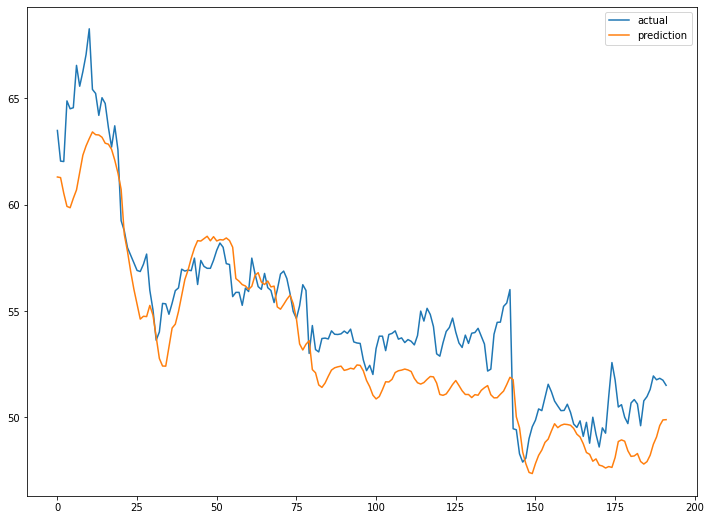

In [17]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[50:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [18]:
unscaled_y = data.iloc[-192:, -2]
y_predicted = model.predict(test_data)

col_name = ['real', 'prediction']
# real = plt.plot(np.asarray(y_test)[20:], label='actual')

real = pd.DataFrame(unscaled_y)
real = real.reset_index().iloc[:,1]
prediction = pd.DataFrame(y_predicted)

foo = pd.concat([real, prediction], axis = 1)
foo.columns = col_name
foo['real+1'] = foo['real'].shift(periods = 1)
foo.corr()

,real,prediction,real+1
real,1.000000,0.849925,0.999589
prediction,0.849925,1.000000,0.845051
real+1,0.999589,0.845051,1.000000


In [19]:
print('train: LOSS, RMSE, MAE', train_metrics)
print('test: LOSS, RMSE, MAE', test_metrics) 
print()
print(foo.corr())

train: LOSS, RMSE, MAE [2.521904945373535, 1.519541621208191, 1.1119120121002197]
test: LOSS, RMSE, MAE [4.575689792633057, 2.0887296199798584, 1.7480400800704956]

                real  prediction    real+1
real        1.000000    0.849925  0.999589
prediction  0.849925    1.000000  0.845051
real+1      0.999589    0.845051  1.000000
